In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pylab as plt
%matplotlib inline

import seaborn as sns

In [3]:
# suffix = '_sel-covid'
# suptitle = 'Top 10 covid removed'
suffix = ''
suptitle = 'All'

df = pd.read_csv(f'combined_data_step{suffix}_7.csv', dtype={'fips': str}).set_index('fips')
with open('steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
print(steps)
df = df.rename(columns={steps[i]: f's{i}' for i in range(len(steps))})
steps_ = [f's{i}' for i in range(len(steps))]

['4-4', '4-11', '4-18', '4-25', '5-2', '5-9', '5-16', '5-23', '5-30', '6-6', '6-13', '6-20', '6-27', '7-4', '7-11', '7-18', '7-25', '8-1', '8-8', '8-15', '8-22', '8-29', '9-5', '9-12', '9-19', '9-26', '10-3', '10-10', '10-17', '10-24']


## Preprocess for regression

In [4]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk', 
    'risk_flu',
    'urban_risk'
]

### Z-ify the covariates and `covidpc`. 
But don't z-ify `covid` because we are going to fit a Poisson

In [5]:
df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,s0,s1,s2,s3,s4,s5,s6,s7,s8,s9,...,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,0.984276,1.006875,0.666999
01003,29,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.225361,1.296454,0.817850
01005,2,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.221392,0.420657,-0.240836
01007,4,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.308118,0.436170,-0.249735
01009,10,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.566669,0.617627,-0.724261


## GLM Models

In [6]:
prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
formulae = {
    # "fat formula cross only": prefix + 'perc_urban_pop:risk_flu',
    # "fat formula full": prefix + 'perc_urban_pop*risk_flu',
    "fat column full": prefix + 'perc_urban_pop+risk_flu+urban_risk',
    "fat column without urban": prefix + 'risk_flu+urban_risk',
    # "slim formula": 'perc_urban_pop*risk_flu',
    "slim column": 'perc_urban_pop+risk_flu+urban_risk',
    "baseline": prefix + 'perc_urban_pop'
}

In [7]:
dfs_coef = {}
dfs_cor_cur = []
dfs_cor_nxt = []
for title, cov in formulae.items():
    dfs, cors_cur, cors_nxt = [], [], []
    for i in range(len(steps_)):
        
        step = steps_[i]
        formula = f'{step}~{cov}'
        
        # model fitting
        model = smf.glm(
            formula=formula,
            data=df_z,
            family=sm.families.Poisson(sm.families.links.log())
        ).fit()
        
        # correlation with the current step
        cor_cur = pd.DataFrame(
            data={
                'pred': model.predict(), 
                'grd': df_z[step].values
            }, 
            index=df_z.index).corr().loc['pred', 'grd']
        
        cors_cur.append(cor_cur)
        
        # correlation with the next step
        if i < len(steps_) - 1:
            next_step = steps_[i + 1]
            cor_nxt = pd.DataFrame(
                data={
                    'pred': model.predict(), 
                    'grd': df_z[next_step].values
                }, 
                index=df_z.index).corr().loc['pred', 'grd']
            cors_nxt.append(cor_nxt)
        
        print(f'{model.summary()}\n\n')
        df_tmp = pd.read_html(model.summary().tables[1].as_html(), header=0, index_col=0)[0]
        df_tmp = df_tmp[['coef']].rename(columns={'coef': step})
        dfs.append(df_tmp)
    
    df_coef = pd.concat(dfs, axis=1).T
    dfs_coef[title] = df_coef
    
    dfs_cor_cur.append(pd.DataFrame(data={title: cors_cur}, index=steps))
    dfs_cor_nxt.append(pd.DataFrame(data={title: cors_nxt}, index=steps[:-1]))

df_cor_cur = pd.concat(dfs_cor_cur, axis=1)
df_cor_nxt = pd.concat(dfs_cor_nxt, axis=1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Sat, 31 Oct 2020   Deviance:                   4.1454e+05
Time:                        01:07:40   Pearson chi2:                 7.18e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0954      0.007    280.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s5   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.1854e+05
Time:                        01:07:41   Pearson chi2:                 4.04e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5307      0.007    381.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s9   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.3315e+05
Time:                        01:07:41   Pearson chi2:                 2.48e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5374      0.007    374.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s13   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.4871e+05
Time:                        01:07:42   Pearson chi2:                 3.78e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0472      0.006    552.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s18   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.0461e+05
Time:                        01:07:43   Pearson chi2:                 2.73e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5871      0.004    908.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s23   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.5912e+05
Time:                        01:07:43   Pearson chi2:                 1.50e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.3651      0.004    771.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s29   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.3408e+05
Time:                        01:07:44   Pearson chi2:                 3.09e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.1645      0.003   1542.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s5   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.1936e+05
Time:                        01:07:44   Pearson chi2:                 4.05e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.6203      0.005    485.621

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s11   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.6839e+05
Time:                        01:07:45   Pearson chi2:                 2.86e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.7051      0.005    509.617

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.8078e+05
Time:                        01:07:46   Pearson chi2:                 3.55e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.6078      0.003   1071.685

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s21   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.6089e+05
Time:                        01:07:47   Pearson chi2:                 1.94e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4821      0.004    954.265

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s26   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3084
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.7752e+05
Time:                        01:07:49   Pearson chi2:                 2.15e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.7165      0.003   1159.443

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s3   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3090
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   3.5093e+05
Time:                        01:07:49   Pearson chi2:                 9.47e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4776      0.006    391.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3090
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   3.3711e+05
Time:                        01:07:50   Pearson chi2:                 5.40e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8851      0.005    534.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s22   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3090
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.4406e+05
Time:                        01:07:50   Pearson chi2:                 3.70e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5502      0.004    927.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s1   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   3.4773e+05
Time:                        01:07:51   Pearson chi2:                 6.44e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.4478      0.009    155.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                     s7   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   1.7342e+05
Time:                        01:07:51   Pearson chi2:                 2.93e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3241      0.007    338.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s13   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   3.7737e+05
Time:                        01:07:52   Pearson chi2:                 5.67e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0459      0.005    636.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s19   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   3.1816e+05
Time:                        01:07:52   Pearson chi2:                 4.79e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5745      0.004    981.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    s25   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3085
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Sat, 31 Oct 2020   Deviance:                   2.6407e+05
Time:                        01:07:53   Pearson chi2:                 3.93e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7091      0.003   1087.

/usr/local/lib64/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib64/python3.7/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
T

Text(0.5, 0.98, 'All')

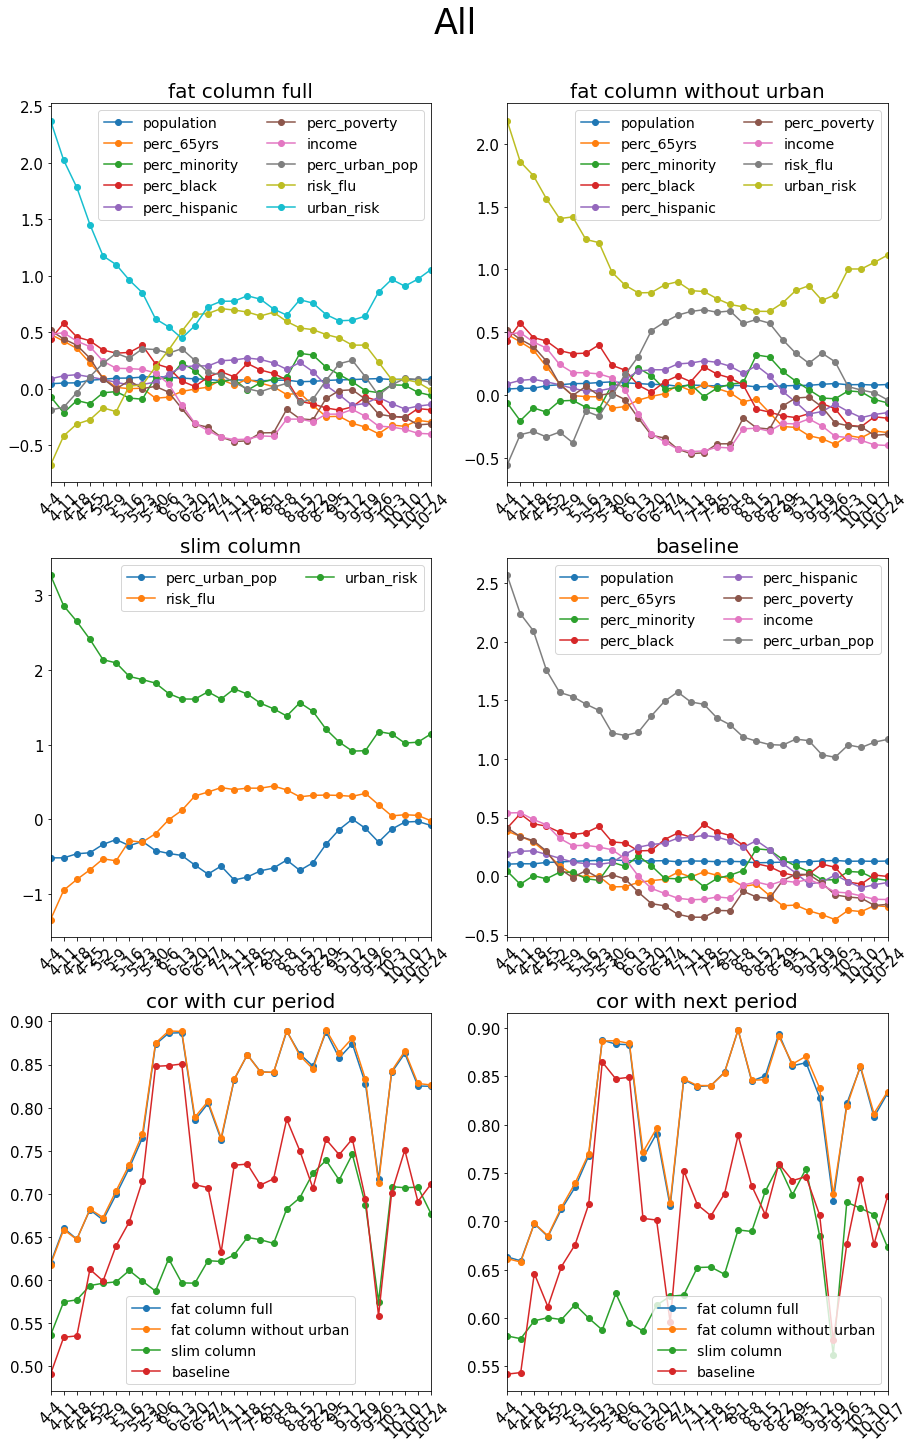

In [10]:
width = 15
height = width * 1.5
fig, axes = plt.subplots(3, 2, figsize=(width, height))

axes = axes.flatten()
i = 0
for title, df_coef in dfs_coef.items():
    ax = axes[i]
    dfs_coef[title].drop(['Intercept'], axis=1).plot(ax=ax, marker='o')
    ax.set_xticks(range(len(steps)))
    ax.set_xticklabels(steps, rotation=45, ha='center')
    ax.tick_params(axis='both', labelsize=15)
    ax.legend(prop=dict(size=14),ncol=2)
    ax.set_title(title, fontsize=20)
    i += 1

ax = axes[-2]
df_cor_cur.plot(ax=ax, marker='o')
ax.set_xticks(range(len(df_cor_cur)))
ax.set_xticklabels(steps, rotation=45, ha='center')
ax.tick_params(axis='both', labelsize=15)
ax.legend(prop=dict(size=14))
ax.set_title('cor with cur period', fontsize=20)

ax = axes[-1]
df_cor_nxt.plot(ax=ax, marker='o')
ax.set_xticks(range(len(df_cor_nxt)))
ax.set_xticklabels(steps[:len(df_cor_nxt)], rotation=45, ha='center')
ax.tick_params(axis='both', labelsize=15)
ax.legend(prop=dict(size=14))
ax.set_title('cor with next period', fontsize=20)

fig.subplots_adjust(top=0.92)
fig.suptitle(suptitle, fontsize=35)

In [13]:
for title, df_coef in dfs_coef.items():
    df_coef.index = steps
    df_coef.drop(['Intercept'], axis=1).to_csv(
        f"coefs_{title.replace(' ', '_')}.csv", 
        float_format='%.6f')

In [14]:
df_cor_cur.to_csv('cor_cur.csv', float_format='%.6f')
df_cor_nxt.to_csv('cor_nxt.csv', float_format='%.6f')